<a href="https://colab.research.google.com/github/Vani-Kumari/capsuleEndoscopy/blob/main/Copy_of_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import swish


In [ ]:
# Paths to your training and validation datasets
train_data_dir = '/content/drive/MyDrive/Capsule Endoscopy Dataset/train_dataset'
test_data_dir = '/content/drive/MyDrive/Capsule Endoscopy Dataset/Test_Dataset'


In [ ]:
# Parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = 8
epochs = 40
learning_rate = 1e-4


In [ ]:
# Image data generators with augmentation for training and normalization for testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the model correctly
)

Found 4020 images belonging to 8 classes.
Found 337 images belonging to 8 classes.


In [ ]:
# Load ResNet50 pre-trained model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))



94765736/94765736 [==============================] - 0s 0us/step


In [ ]:

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True


In [ ]:

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation=swish)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)


Epoch 1/40
126/126 [==============================] - 1501s 12s/step - loss: 0.7176 - accuracy: 0.7567 - val_loss: 2.2267 - val_accuracy: 0.1513
Epoch 2/40
126/126 [==============================] - 119s 946ms/step - loss: 0.3656 - accuracy: 0.8736 - val_loss: 2.5015 - val_accuracy: 0.1098
Epoch 3/40
126/126 [==============================] - 120s 948ms/step - loss: 0.2989 - accuracy: 0.8923 - val_loss: 2.8265 - val_accuracy: 0.2136
Epoch 4/40
126/126 [==============================] - 120s 946ms/step - loss: 0.2503 - accuracy: 0.9100 - val_loss: 2.7910 - val_accuracy: 0.1662
Epoch 5/40
126/126 [==============================] - 120s 948ms/step - loss: 0.2113 - accuracy: 0.9219 - val_loss: 3.1230 - val_accuracy: 0.2433
Epoch 6/40
126/126 [==============================] - 122s 967ms/step - loss: 0.1713 - accuracy: 0.9383 - val_loss: 1.7122 - val_accuracy: 0.4570
Epoch 7/40
126/126 [==============================] - 120s 948ms/step - loss: 0.1546 - accuracy: 0.9425 - val_loss: 1.2229 - 

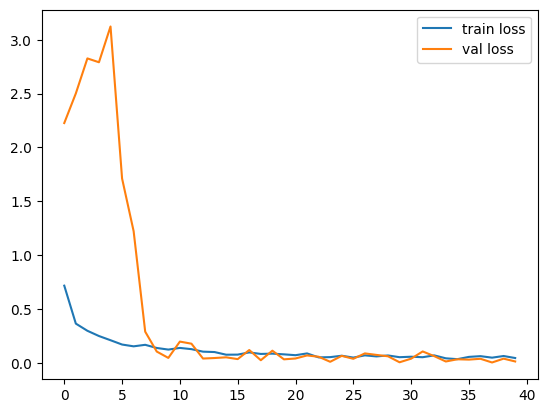

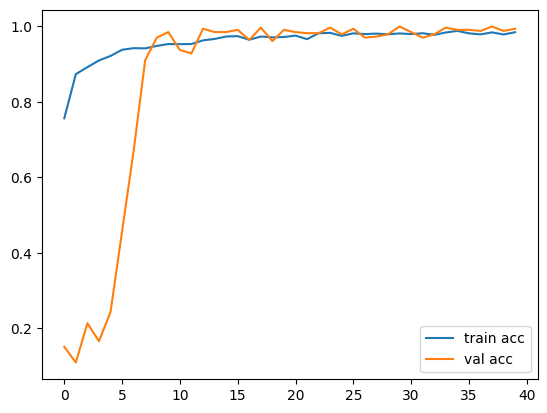

<Figure size 640x480 with 0 Axes>

In [ ]:

# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# Save the model
model.save('capsule_endoscopy_resnet50.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy * 100:.2f}%')

11/11 [==============================] - 5s 411ms/step - loss: 0.0143 - accuracy: 0.9941
Test accuracy: 99.41%


In [ ]:
# Make predictions on the test dataset
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes


11/11 [==============================] - 6s 442ms/step


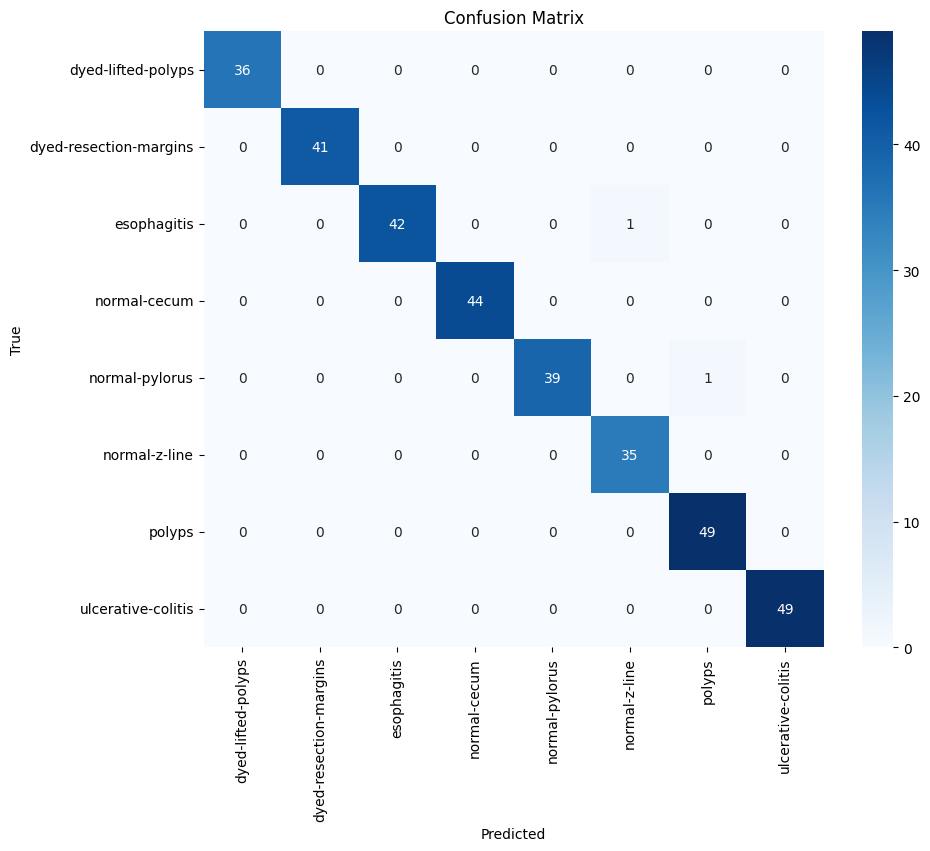

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Compute all classification metrics
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)
support = cm.sum(axis=1)

print(f'Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Support:', support)


Accuracy: 99.41%
Precision: [1.         1.         1.         1.         1.         0.97222222
 0.98       1.        ]
Recall: [1.         1.         0.97674419 1.         0.975      1.
 1.         1.        ]
F1 Score: [1.         1.         0.98823529 1.         0.98734177 0.98591549
 0.98989899 1.        ]
Support: [36 41 43 44 40 35 49 49]


In [ ]:
# Print classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

Classification Report
                        precision    recall  f1-score   support

    dyed-lifted-polyps       1.00      1.00      1.00        36
dyed-resection-margins       1.00      1.00      1.00        41
           esophagitis       1.00      0.98      0.99        43
          normal-cecum       1.00      1.00      1.00        44
        normal-pylorus       1.00      0.97      0.99        40
         normal-z-line       0.97      1.00      0.99        35
                polyps       0.98      1.00      0.99        49
    ulcerative-colitis       1.00      1.00      1.00        49

              accuracy                           0.99       337
             macro avg       0.99      0.99      0.99       337
          weighted avg       0.99      0.99      0.99       337

